In [2]:
import os
import tempfile
import shutil
from typing import List
from cog import BasePredictor, Path, Input, BaseModel

from openpsg.utils.utils import show_result
from mmdet.apis import init_detector, inference_detector
from mmcv import Config
import mmcv

from matplotlib import pyplot as plt
import torch
import numpy as np
import random
from panopticapi.utils import rgb2id

In [3]:
class ModelOutput(BaseModel):
    image: Path
    
model_ckt = "./work_dirs/checkpoints/epoch_60.pth"
cfg = Config.fromfile("configs/psgtr/psgtr_r50_psg_inference.py")
model = init_detector(cfg, model_ckt, device="cpu")

load checkpoint from local path: ./work_dirs/checkpoints/epoch_60.pth


In [4]:
image = '../dataset/coco/test2017/000000000509.jpg'
# num_rel = Input(default=5,ge=1,le=20)
num_rel = 15

List[ModelOutput]
input_image = mmcv.imread(str(image))
result = inference_detector(model, input_image)
# out_path = Path(tempfile.mkdtemp()) / "output.png"
out_path = './tmp/total_predict_img/output.png'
out_dir = "./tmp"
show_result(
    image,
    result,
    is_one_stage=True,
    num_rel=num_rel,
    out_dir=out_dir,
    out_file=str(out_path)
)

/home/mini/miniconda3/envs/openpsg/lib/python3.7/site-packages/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


In [5]:
rel_dists = result.rel_dists
# rel_dists = result.rel_dists
rel_scores = rel_dists.max(1)
# rel_scores = result.triplet_scores
# Extract relations with top scores
rel_topk_idx = np.argpartition(rel_scores, -num_rel)[-num_rel:]
rel_labels_topk = rel_dists[rel_topk_idx].argmax(1)
rel_pair_idxes_topk = result.rel_pair_idxes[rel_topk_idx]
relations = np.concatenate(
    [rel_pair_idxes_topk, rel_labels_topk[..., None]], axis=1)

rel_obj_labels = [model.CLASSES[i-1] for i in result.labels]

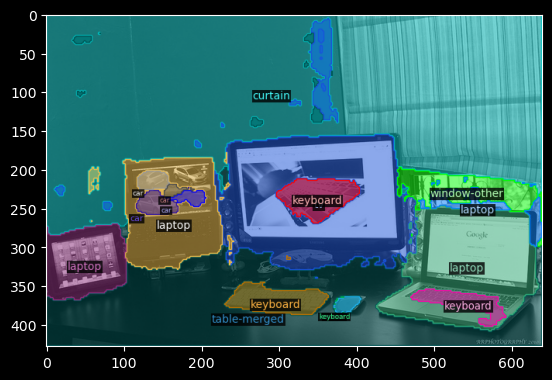

In [6]:
output = []
output.append(str(out_path))
out_dir = './tmp/total_predict_img/'
for i, img_path in enumerate(os.listdir(out_dir)):
    # print(img_path, out_dir)
    img = mmcv.imread(os.path.join(out_dir, img_path))
    out_path = '/tmp/tmpac58xx1c/' f"output_{i}.png"
    mmcv.imwrite(img, str(out_path))
    plt.imshow(img)
# shutil.rmtree(out_dir)


In [7]:
for i, r in enumerate(relations):
    s_idx, o_idx, rel_id = r
    s_label = rel_obj_labels[s_idx]
    o_label = rel_obj_labels[o_idx]
    rel_label = model.PREDICATES[rel_id]
    print(s_label, rel_label, o_label)

car on car
car on car
laptop on laptop
mouse on keyboard
mouse on laptop
keyboard on laptop
laptop on tv
laptop in table-merged
keyboard on mouse
mouse on keyboard
laptop in table-merged
laptop in table-merged
mouse in table-merged
tv in table-merged
keyboard in table-merged
